In [1]:
# --- IMPORT LIBRARY ---
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [2]:
# Fungsi untuk memproses _classes.csv
def preprocess_csv(csv_path, base_dir):
    df = pd.read_csv(csv_path)
    class_columns = [col for col in df.columns if col != 'filename']
    df['label'] = df[class_columns].idxmax(axis=1)
    df['filepath'] = df['filename'].apply(lambda x: os.path.join(base_dir, x))
    return df[['filepath', 'label']]


In [3]:
# Load dan proses data
train_df = preprocess_csv('dataset/train/_classes.csv', 'dataset/train')
valid_df = preprocess_csv('dataset/valid/_classes.csv', 'dataset/valid')
test_df  = preprocess_csv('dataset/test/_classes.csv',  'dataset/test')

In [4]:
# Image Data Generator dengan augmentasi
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

valid_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    train_df, x_col='filepath', y_col='label',
    target_size=img_size, batch_size=batch_size,
    class_mode='categorical', shuffle=True
)

valid_generator = valid_test_datagen.flow_from_dataframe(
    valid_df, x_col='filepath', y_col='label',
    target_size=img_size, batch_size=batch_size,
    class_mode='categorical', shuffle=False
)

test_generator = valid_test_datagen.flow_from_dataframe(
    test_df, x_col='filepath', y_col='label',
    target_size=img_size, batch_size=1,
    class_mode='categorical', shuffle=False
)

Found 2740 validated image filenames belonging to 6 classes.
Found 367 validated image filenames belonging to 6 classes.
Found 184 validated image filenames belonging to 6 classes.


In [5]:
# Class Weights
y_train = train_generator.classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))


In [6]:
# Model MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(224,224,3)))
base_model.trainable = False  # Freeze saat awal training

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


C:\Users\Ade Indra\AppData\Local\Temp\ipykernel_20824\3733708544.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(224,224,3)))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
# Callbacks
earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)

In [8]:
# Training tahap 1 (feature extraction)
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=15,
    callbacks=[earlystop, reduce_lr],
    class_weight=class_weights
)


C:\ProgramData\anaconda3\envs\laskarai_capstone\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


C:\ProgramData\anaconda3\envs\laskarai_capstone\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


86/86 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.6520 - loss: 0.9899 - val_accuracy: 0.9782 - val_loss: 0.0605 - learning_rate: 0.0010
Epoch 2/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.9464 - loss: 0.1404 - val_accuracy: 0.9891 - val_loss: 0.0473 - learning_rate: 0.0010
Epoch 3/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.9501 - loss: 0.1112 - val_accuracy: 0.9864 - val_loss: 0.0446 - learning_rate: 0.0010
Epoch 4/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.9698 - loss: 0.0748 - val_accuracy: 0.9837 - val_loss: 0.0326 - learning_rate: 0.0010
Epoch 5/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.9684 - loss: 0.0729 - val_accuracy: 0.9809 - val_loss: 0.0486 - learning_rate: 0.0010
Epoch 6/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.9714 - loss: 0.0735 - val_accuracy: 0.9891 - val_loss: 0.0226 - learning_rate: 0.0010
Epoch 7/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.9799 - loss: 0.0469 - val_accuracy: 0.98

In [9]:
# Fine-tuning tahap 2
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

fine_tune_history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[earlystop, reduce_lr],
    class_weight=class_weights
)


Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.9267 - loss: 0.2249 - val_accuracy: 0.9946 - val_loss: 0.0185 - learning_rate: 1.0000e-05
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.9640 - loss: 0.0977 - val_accuracy: 0.9973 - val_loss: 0.0156 - learning_rate: 1.0000e-05
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.9673 - loss: 0.0800 - val_accuracy: 0.9973 - val_loss: 0.0147 - learning_rate: 1.0000e-05
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9641 - loss: 0.0849 - val_accuracy: 0.9973 - val_loss: 0.0124 - learning_rate: 1.0000e-05
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.9783 - loss: 0.0545 - val_accuracy: 0.9973 - val_loss: 0.0093 - learning_rate: 1.0000e-05
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.9852 - loss: 0.0408 - val_accuracy: 0.9973 - val_loss: 0.0083 - learning_rate: 1.0000e-05
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.9795 

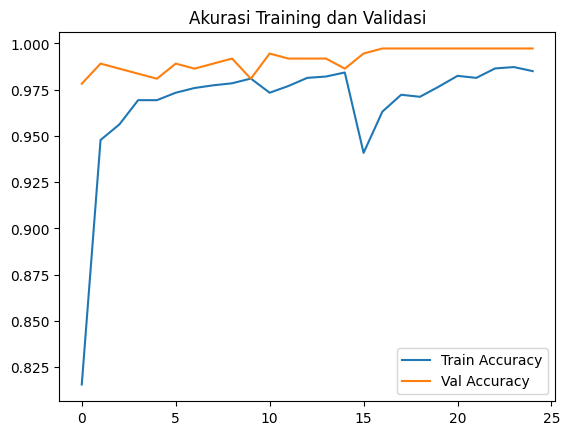

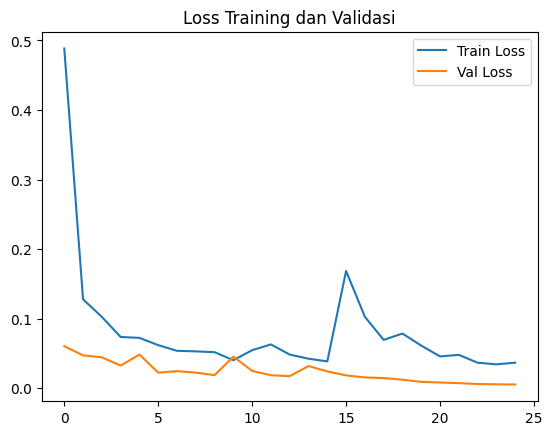

In [10]:
# Visualisasi Akurasi dan Loss
plt.plot(history.history['accuracy'] + fine_tune_history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + fine_tune_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Akurasi Training dan Validasi')
plt.legend()
plt.show()

plt.plot(history.history['loss'] + fine_tune_history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + fine_tune_history.history['val_loss'], label='Val Loss')
plt.title('Loss Training dan Validasi')
plt.legend()
plt.show()

C:\ProgramData\anaconda3\envs\laskarai_capstone\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


184/184 ━━━━━━━━━━━━━━━━━━━━ 18s 81ms/step
                         precision    recall  f1-score   support

Anorganik-botol-plastik       1.00      0.97      0.99        40
         Anorganik-kaca       1.00      1.00      1.00         9
       Anorganik-masker       0.98      1.00      0.99        40
    Organik-daun-kering       1.00      1.00      1.00        15
    Organik-jeruk-busuk       1.00      1.00      1.00        40
   Organik-kulit-pisang       1.00      1.00      1.00        40

               accuracy                           0.99       184
              macro avg       1.00      1.00      1.00       184
           weighted avg       0.99      0.99      0.99       184



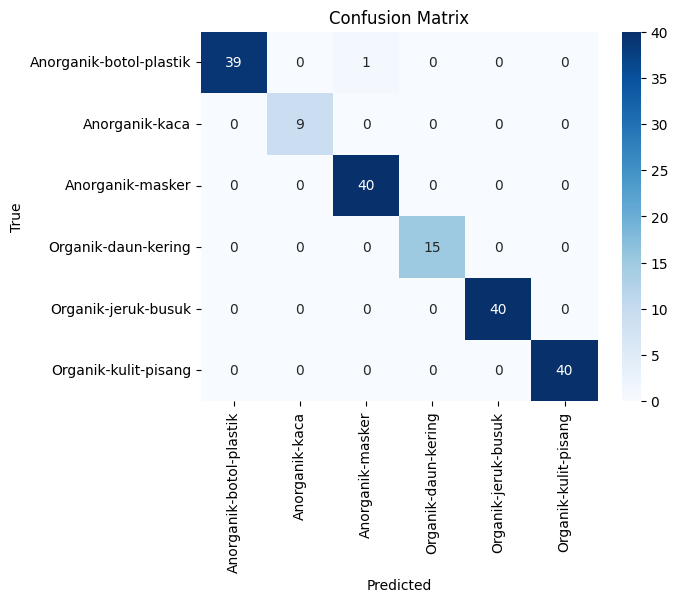

In [11]:
# Evaluasi akhir
test_generator.reset()
y_pred = np.argmax(model.predict(test_generator), axis=1)
y_true = test_generator.classes
labels = list(test_generator.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=labels))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [12]:
import tensorflow as tf
import tf2onnx

# Simpan model ke format SavedModel (untuk ONNX)
model.export("saved_model")

# Konversi ke ONNX
spec = (tf.TensorSpec((None, 224, 224, 3), tf.float32, name="input"),)
model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13)
with open("model_sampah.onnx", "wb") as f:
    f.write(model_proto.SerializeToString())


C:\ProgramData\anaconda3\envs\laskarai_capstone\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  2290959921920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2290960282192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2290960282368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2290959924384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2290959924560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2290960285536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2290964390128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2290964390304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2290964375680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2290964376736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2290964393648: TensorSpec(shape=(), dty

C:\ProgramData\anaconda3\envs\laskarai_capstone\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


In [13]:
import onnx

model_onnx = onnx.load("model_sampah.onnx")
onnx.checker.check_model(model_onnx)
print("✅ Model ONNX valid dan siap digunakan.")

✅ Model ONNX valid dan siap digunakan.
